<a id="home"></a>
## Table of content
1. [EDA](#eda)
    1. [Labels]
2. [Modeling](#modeling)

<a id="eda"></a>
## EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print(train_data.info())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
missing_values_count = train_data.isna().sum().sort_values(ascending=False)
missing_values_count[:3]


PoolQC         1453
MiscFeature    1406
Alley          1369
dtype: int64

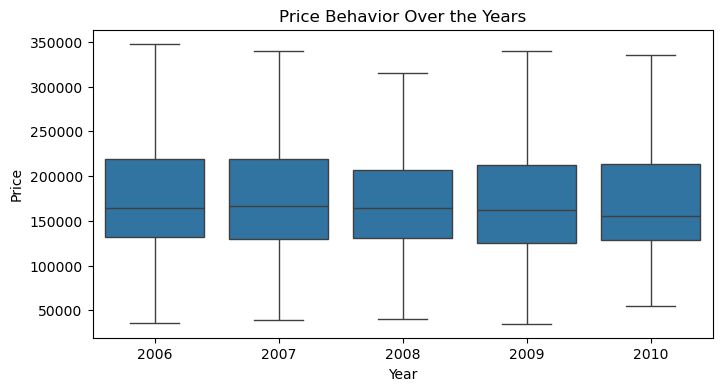

In [4]:
plt.figure(figsize=(8, 4))  
sns.boxplot(x='YrSold', y='SalePrice', data=train_data, showfliers=False)
plt.title('Price Behavior Over the Years')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

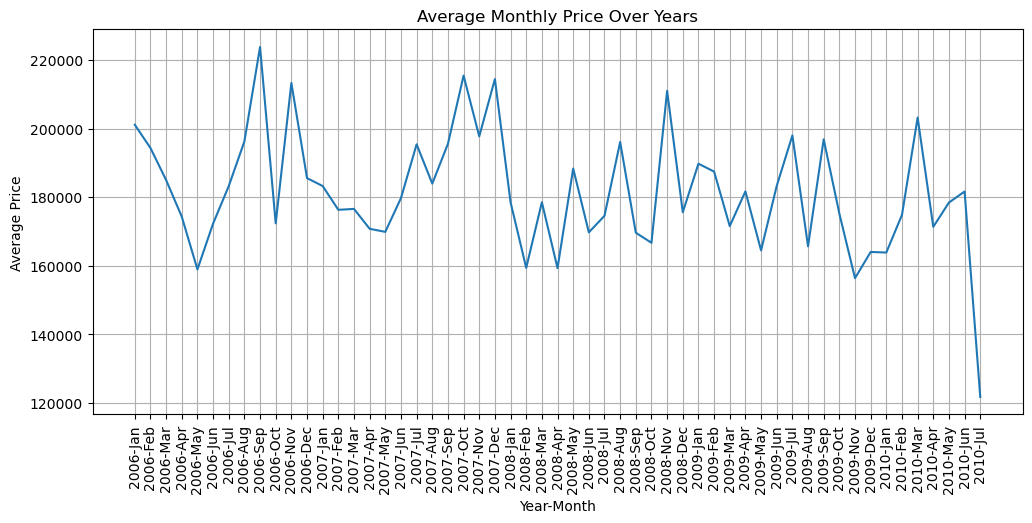

In [5]:
monthly_prices = train_data.groupby(["YrSold", "MoSold"])["SalePrice"].mean().reset_index()
monthly_prices["MonthName"] = monthly_prices['MoSold'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))

monthly_prices["YearMonth"] = monthly_prices["YrSold"].astype(str) + '-' + monthly_prices["MonthName"]
monthly_prices = monthly_prices.sort_values(by=["YrSold", "MoSold"])

plt.figure(figsize=(12, 5))
sns.lineplot(x='YearMonth', y='SalePrice', data=monthly_prices)

plt.xticks(rotation=90)  
plt.title('Average Monthly Price Over Years')
plt.xlabel('Year-Month')
plt.ylabel('Average Price')
plt.grid(True) 

plt.show()

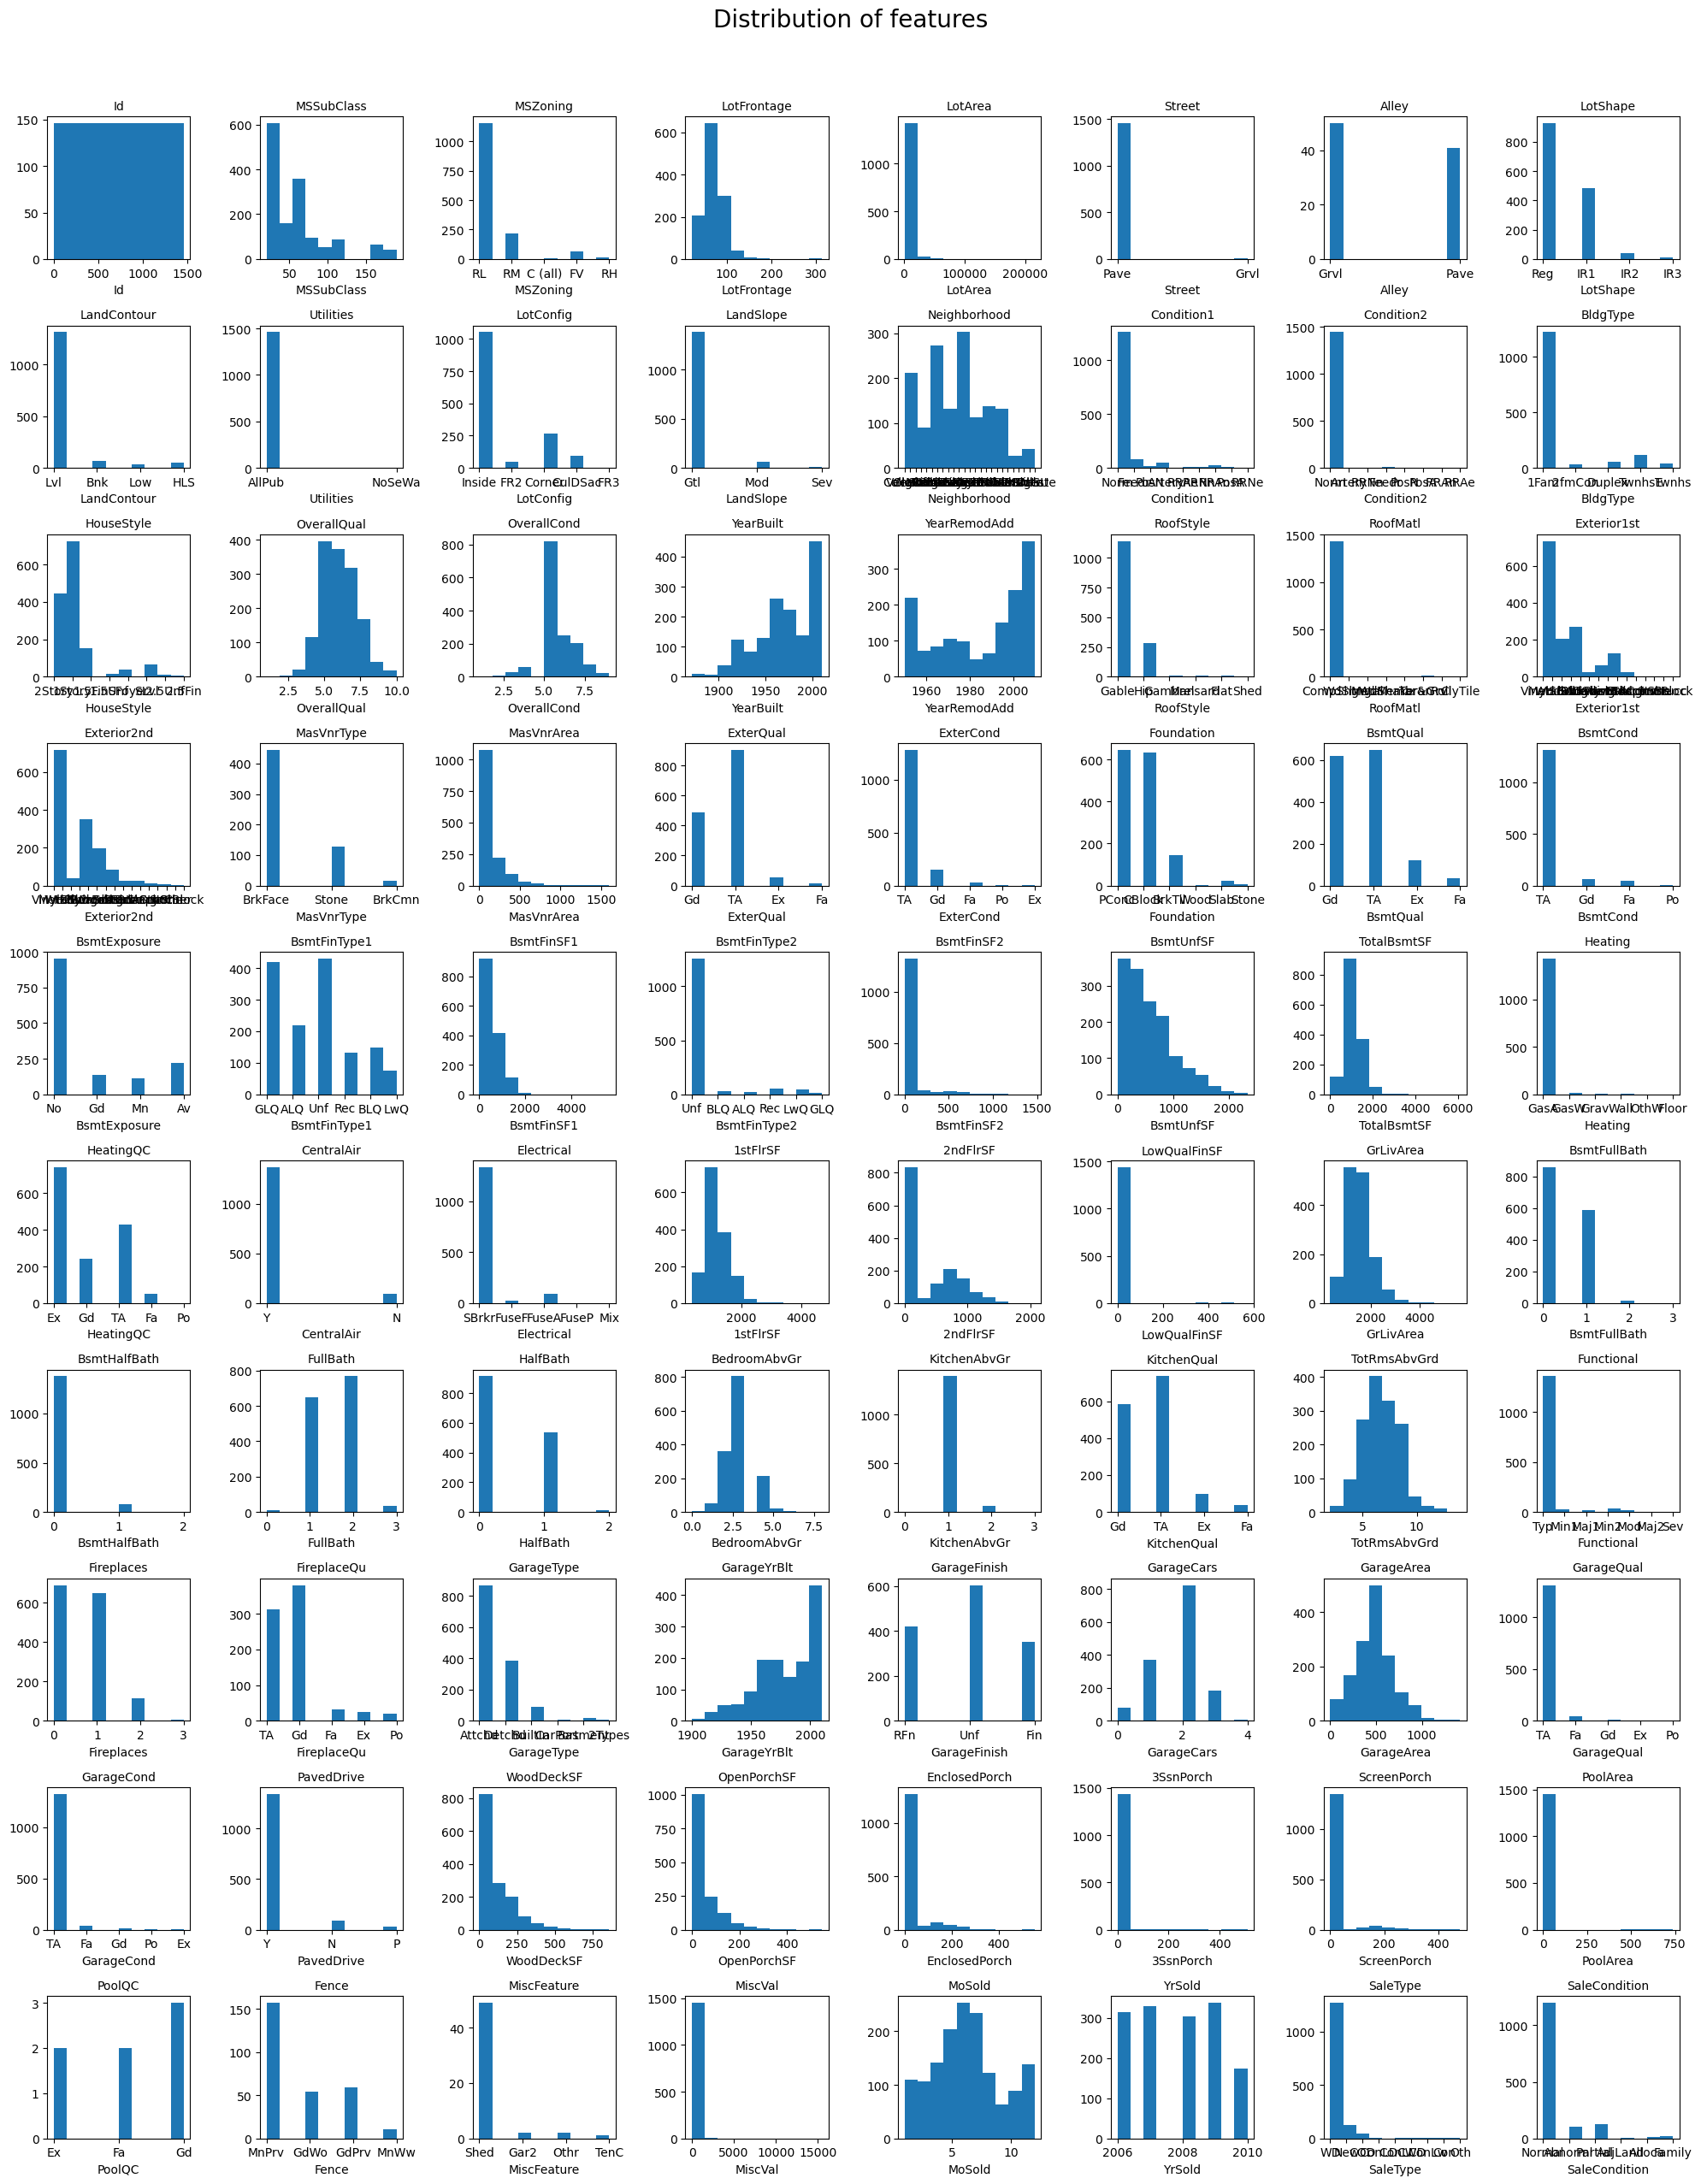

In [20]:
num_features = len(train_data.columns) - 1

fig, axs = plt.subplots(nrows=10, ncols=8, figsize=(20, 25))
axs = axs.ravel()
for i in range(num_features):
    column = train_data.columns[i] 
    column_data = train_data[column].dropna()
    axs[i].hist(column_data)
    axs[i].set_title(train_data.columns[i], fontsize=10)
    axs[i].set_xlabel(column)

fig.suptitle("Distribution of features", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

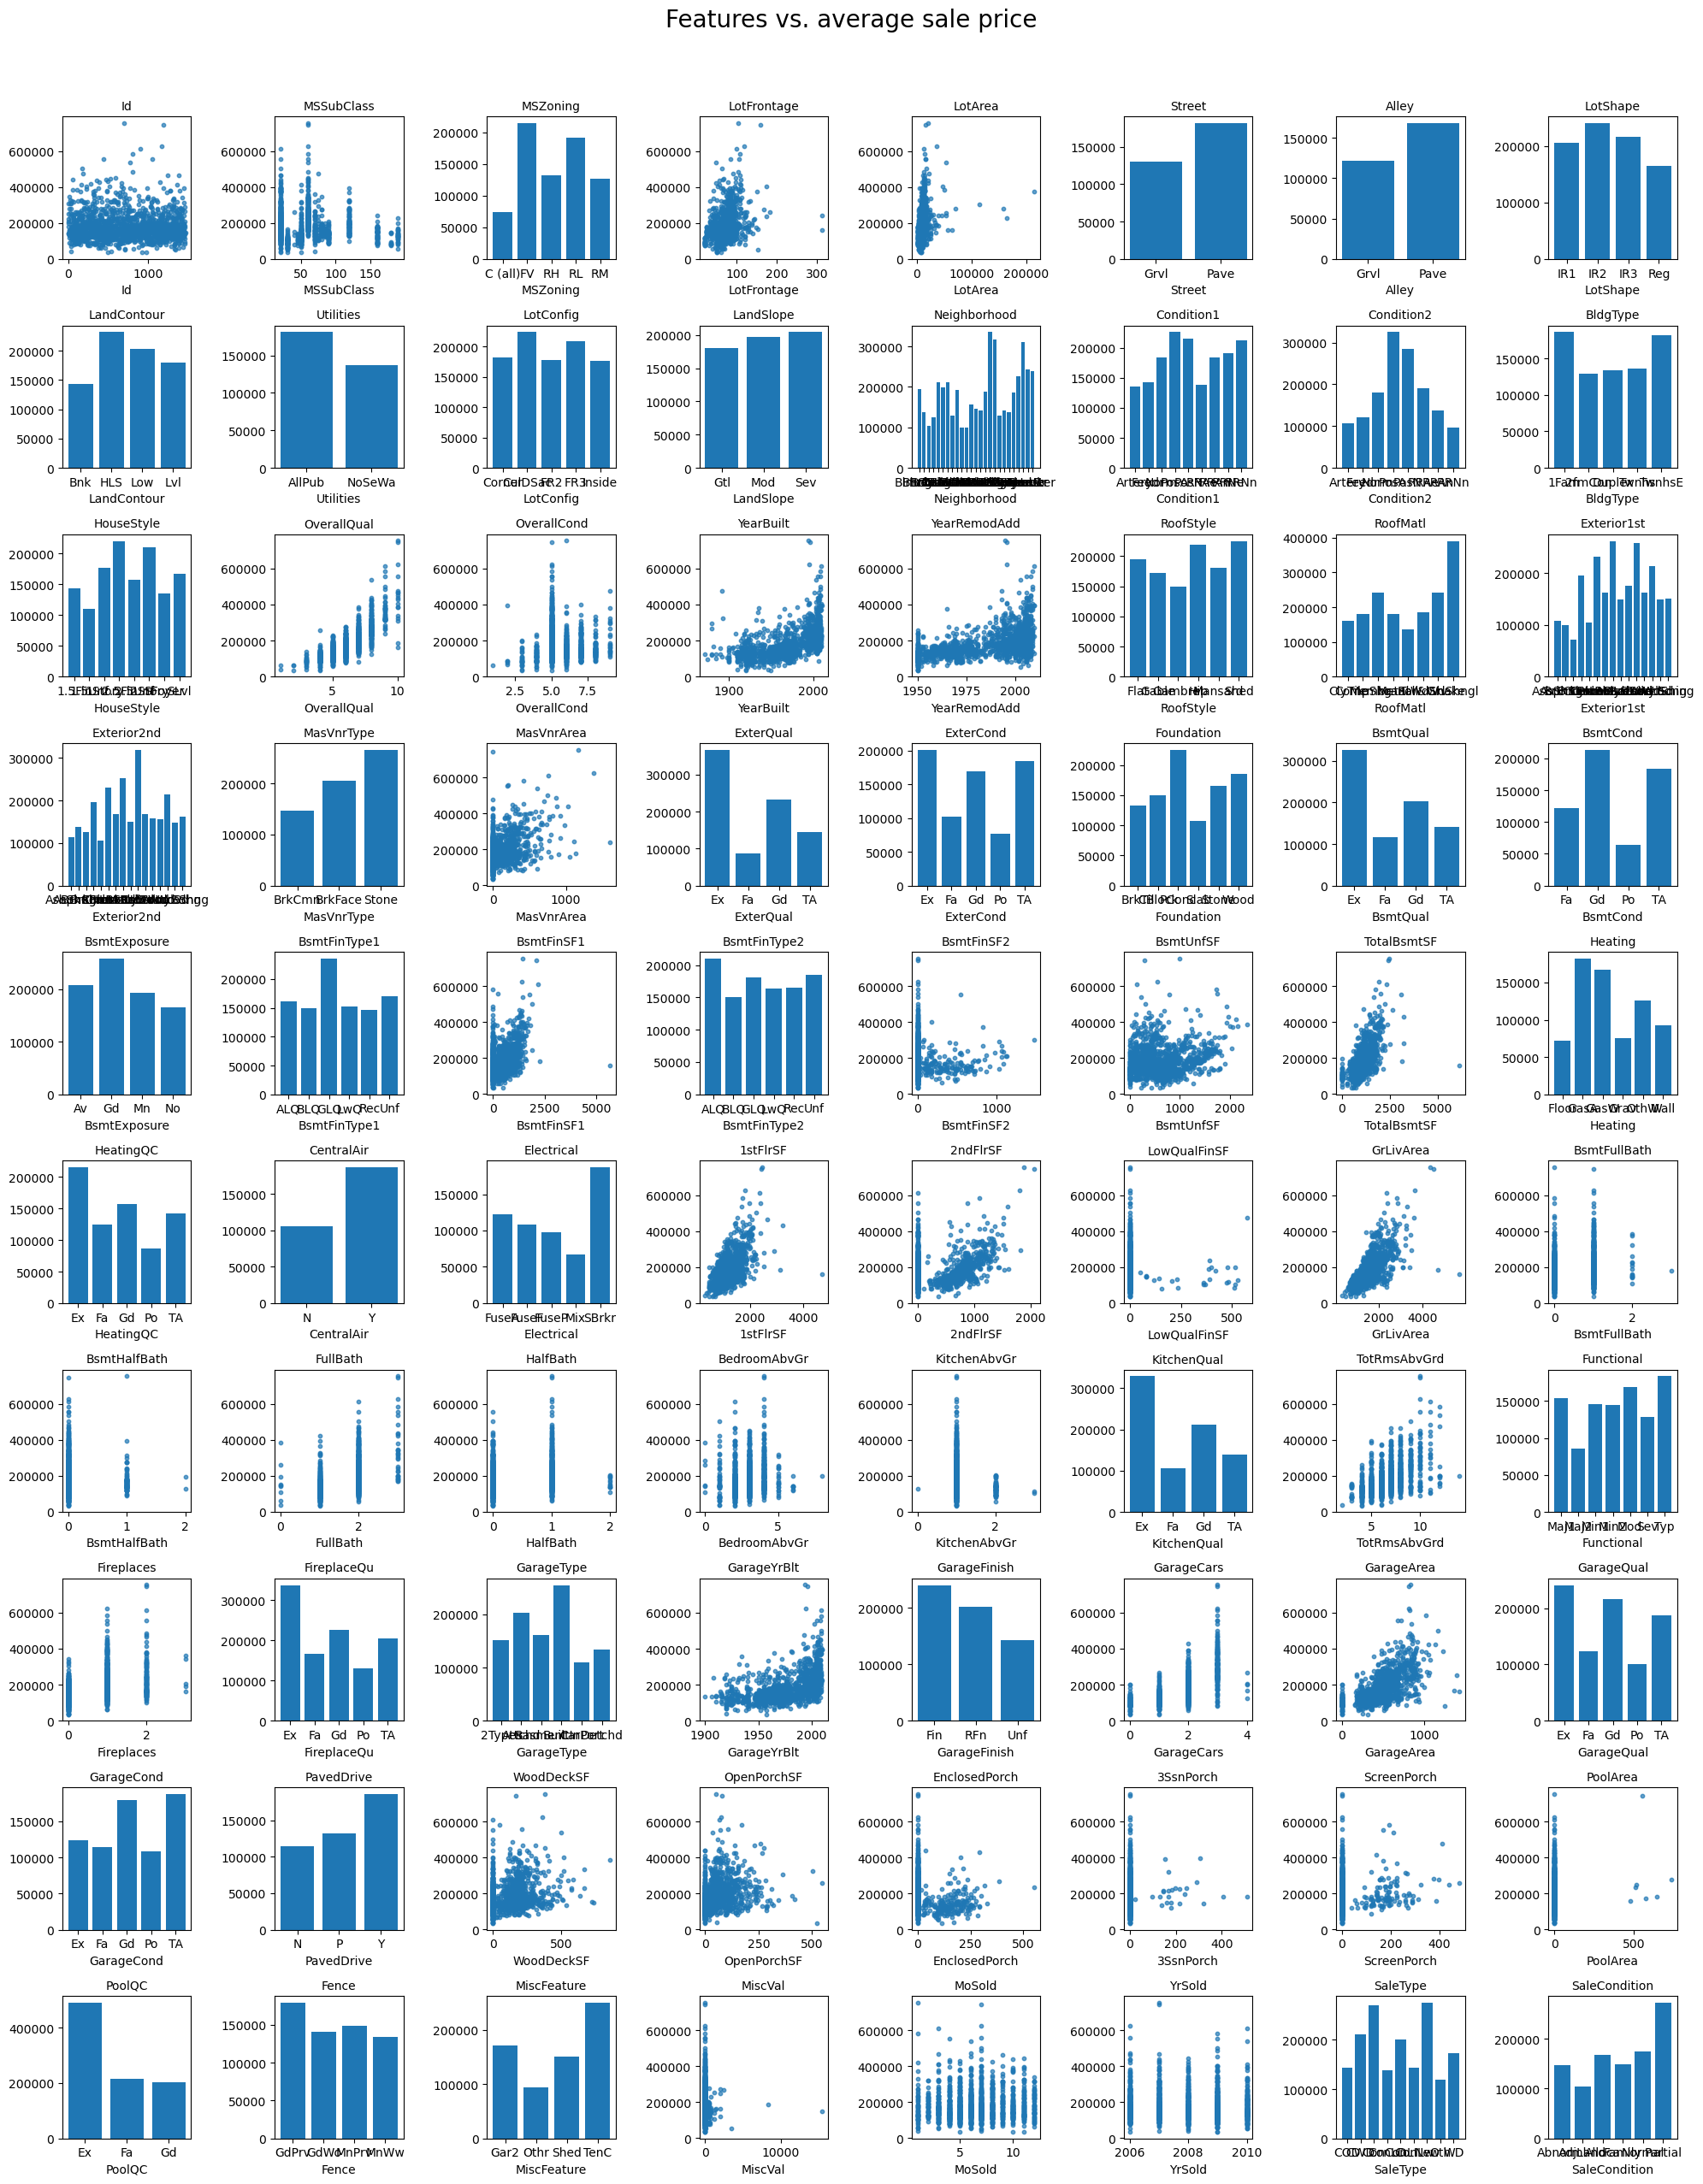

In [26]:
fig, axs = plt.subplots(nrows=10, ncols=8, figsize=(20, 25))
axs = axs.ravel()
for i in range(num_features):
    column = train_data.columns[i] 
    if train_data[column].dtypes == 'object':
        avg_price = train_data.groupby(column)["SalePrice"].mean()
        axs[i].bar(avg_price.index, avg_price.values)
    else:
        axs[i].scatter(train_data[column], train_data["SalePrice"], alpha=0.7, s=10)
        
    axs[i].set_title(train_data.columns[i], fontsize=10)
    axs[i].set_xlabel(column)

fig.suptitle("Features vs. average sale price", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

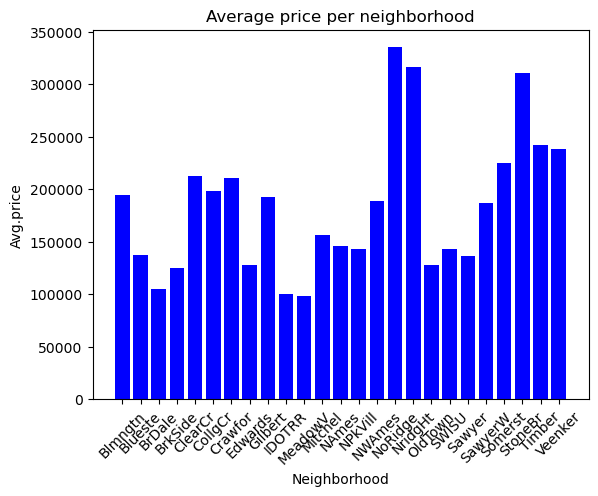

In [8]:
avg_price_neigh = train_data.groupby("Neighborhood")["SalePrice"].mean()

plt.bar(avg_price_neigh.index, avg_price_neigh.values, color='blue')

plt.title("Average price per neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Avg.price")

plt.xticks(rotation=45)
plt.show()

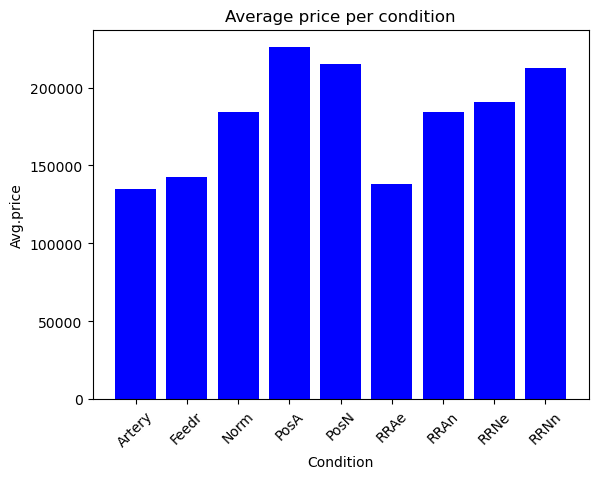

In [9]:
avg_price_neigh = train_data.groupby("Condition1")["SalePrice"].mean()

plt.bar(avg_price_neigh.index, avg_price_neigh.values, color='blue')

plt.title("Average price per condition")
plt.xlabel("Condition")
plt.ylabel("Avg.price")

plt.xticks(rotation=45)
plt.show()

In [10]:
from sklearn.preprocessing import LabelEncoder

def label_encoding(df, columns, values):
    items = [item.strip() for item in values.split(',')]
    
    mapping = {item: len(items)-index-1 for index, item in enumerate(items)}
    df[columns] = df[columns].replace(mapping)
    return df

def joint_one_hot(df, columns, prefix, categories):
    df[columns[0]] = pd.Categorical(df[columns[0]], categories=categories)
    df = pd.get_dummies(df, columns=[columns[0]], prefix=prefix)
    for col in columns[1:]:
        values = df[col].unique()
        for val in values:
            df[f"{prefix}_{val}"] += (df[col]==val)
        df.drop(col, axis=1, inplace=True)
    return df

def df_preprocessing(df):
    df_prep = df.copy()
    df_prep['Date'] = pd.to_datetime(df_prep['YrSold'].astype(str) + '-' +
                                     df_prep['MoSold'].astype(str) + '-01')
    df_prep = df_prep.drop(['YrSold', 'MoSold'], axis=1)

    #label encoding
    label_encoding(df_prep, 
                   ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu",
                        "GarageQual", "GarageCond", "PoolQC"],
                   "Ex, Gd, TA, Fa, Po, NA")

    label_encoding(df_prep, ["BsmtExposure"],
                    "Gd, Av, Mn, No, NA")

    label_encoding(df_prep, ["BsmtFinType1", "BsmtFinType2"],
                    "GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA")
   
    # one-hot encoding for columns "Neighborhood"
    df_prep = pd.get_dummies(df_prep, columns=['Neighborhood'])

    #joint one-hot for columns Condition1 & Condition2
    df_prep = joint_one_hot(df_prep, ["Condition1", "Condition2"], 
                                    "Condition",
                                    ["Artery", "Feedr", "Norm", "RRNn", "RRAn", "PosN", "PosA", "RRNe", "RRAe"])
    
    df_prep.drop(["Condition_Norm"], axis=1, inplace=True)

    replace_val = {'Wd Sdng': 'WdSdng', 'Wd Shng': 'WdShing', 'CmentBd': 'CemntBd', 'Brk Cmn': 'BrkComm'}
    df_prep["Exterior1st"] = df_prep["Exterior1st"].replace(replace_val)
    df_prep["Exterior2nd"] = df_prep["Exterior2nd"].replace(replace_val)
    df_prep = joint_one_hot(df_prep, ["Exterior1st", "Exterior2nd"], 
                                    "Exterior",
                                    ["AsbShng", "AsphShn", "BrkComm", "BrkFace", "CBlock", "CemntBd", 
                                     "HdBoard", "ImStucc", "MetalSd", "Other", "Plywood", "PreCast", 
                                     "Stone", "Stucco", "VinylSd", "WdSdng", "WdShing"])
    
    df_prep = pd.get_dummies(data=df_prep, columns=["MSZoning"])

    #We don't need column "Id"
    #"Utilities" has 1 value "NoSeWa", other - "AllPub"
    df_prep = df_prep.drop(["Id", "Utilities"], axis=1)
    
    #Street and Alley 
    df_prep = pd.get_dummies(data=df_prep, columns=["Alley", "Street"])
    return df_prep

df_prep = df_preprocessing(train_data)
num_object_columns = train_data.select_dtypes(include=['object']).shape[1]
num_object_columns2 = df_prep.select_dtypes(include=['object']).shape[1]
num_object_columns, num_object_columns2
#df_prep.iloc[29][-10:]



(43, 21)

In [11]:
train_data_with_dummies = pd.get_dummies(df_prep, drop_first=True)
correlation_matrix = df_prep.corr(method='pearson', numeric_only=True)

correlation_matrix = correlation_matrix['SalePrice'].drop('SalePrice')

sorted_correlation = correlation_matrix.sort_values(ascending=False)
print(sorted_correlation.head(15))
print(sorted_correlation.tail(10))

OverallQual     0.790982
GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
BsmtQual        0.644019
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Name: SalePrice, dtype: float64
Alley_Grvl             -0.139195
Neighborhood_BrkSide   -0.143648
Exterior_WdSdng        -0.154201
Neighborhood_IDOTRR    -0.164056
Exterior_MetalSd       -0.168906
Neighborhood_Edwards   -0.179949
Neighborhood_NAmes     -0.188513
Neighborhood_OldTown   -0.192189
MSZoning_RM            -0.288065
Exterior_PreCast             NaN
Name: SalePrice, dtype: float64


<a id="labels"></a>
[home](#home)

<a id="modeling"></a>
## Modeling

<a id="labels"></a>
[home](#home)

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

features =["LotArea", "YearBuilt", "OverallQual", "KitchenQual", "GrLivArea","1stFlrSF"]
features.extend([col for col in df_prep.columns if col.startswith("Neighborhood")])

#X = train_data[features]
#y = train_data["SalePrice"]
X = df_prep[features]
y = df_prep["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge = Ridge(alpha=1.0)  
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1296087625.6156971


In [46]:
X_test_subm = test_data[features]

y_pred = ridge.predict(X_test_subm)

data = {"Id": test_data["Id"], "SalePrice": y_pred}
df = pd.DataFrame(data)

df.to_csv("submission.csv", index=False)